### Importing Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import seaborn as sns

### Using a specific stock such as Apple Stocks from yahoo finance. I used yfinance library to download the specific stock data.

In [2]:
# Downloading historical price data for a specific stock such as Apple INc. (e.g., AAPL) using yfinance.
apple_data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


### EDA

##### Inspection of data


In [3]:
# Print the first few rows of the data
print(apple_data.head())

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.461978  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.473150  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.370185  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.358408  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.400681  447610800


In [4]:
# Printing the dataset info
print(apple_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3522 non-null   float64
 1   High       3522 non-null   float64
 2   Low        3522 non-null   float64
 3   Close      3522 non-null   float64
 4   Adj Close  3522 non-null   float64
 5   Volume     3522 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 192.6 KB
None


In [5]:
# Summary statistics
print(apple_data.describe())

              Open         High          Low        Close    Adj Close  \
count  3522.000000  3522.000000  3522.000000  3522.000000  3522.000000   
mean     59.883701    60.528731    59.267621    59.926226    57.768186   
std      55.387520    56.014467    54.812449    55.444533    55.706710   
min       6.870357     7.000000     6.794643     6.858929     5.798901   
25%      19.680447    19.832321    19.402321    19.608571    17.005855   
50%      32.303749    32.633751    32.078751    32.340000    29.137094   
75%      91.213125    92.512501    90.425623    91.207499    89.074635   
max     198.020004   199.619995   197.000000   198.110001   197.589523   

             Volume  
count  3.522000e+03  
mean   2.422834e+08  
std    2.204578e+08  
min    2.404830e+07  
25%    9.266760e+07  
50%    1.526602e+08  
75%    3.284715e+08  
max    1.880998e+09  


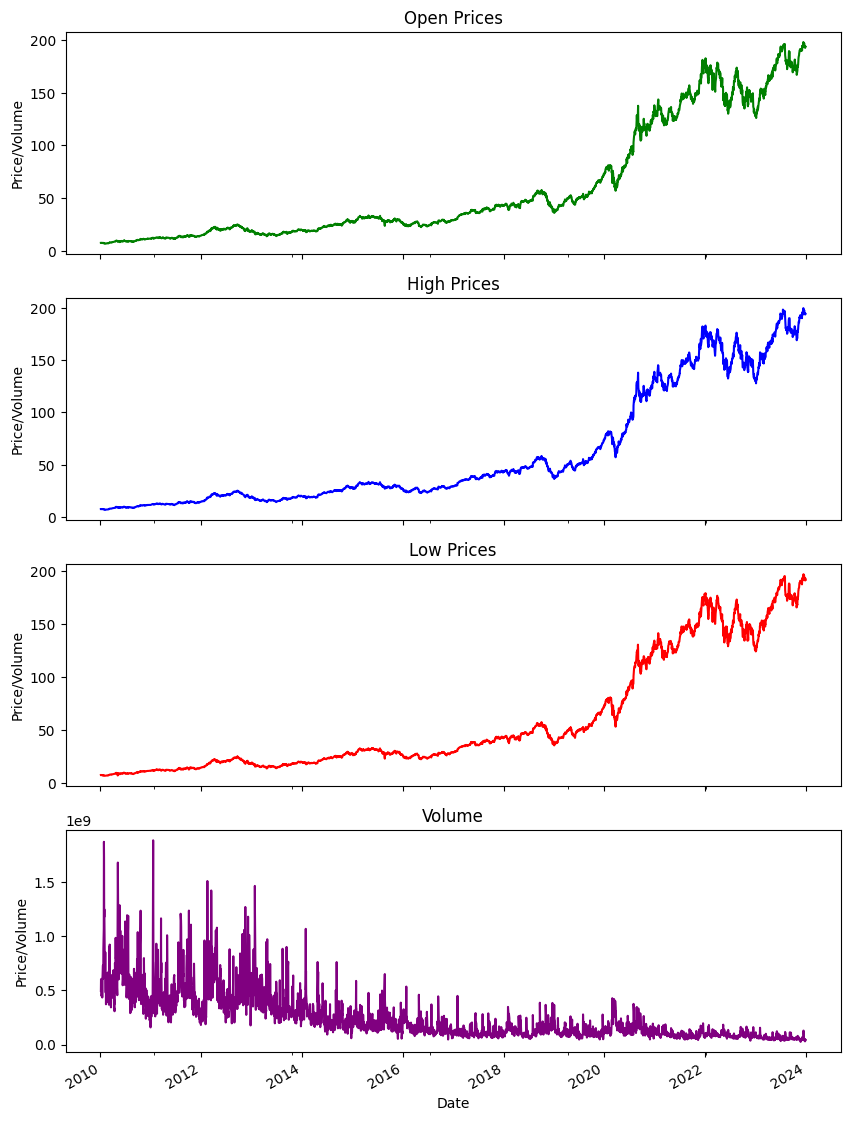

In [6]:
# Visualize other datas like Open, High, Low, Volume
fig, axs = plt.subplots(4, 1, figsize =(10, 15), sharex=True)

apple_data['Open'].plot(ax=axs[0], color='green', title='Open Prices')
apple_data['High'].plot(ax=axs[1], color='blue', title='High Prices')
apple_data['Low'].plot(ax=axs[2], color='red', title='Low Prices')
apple_data['Volume'].plot(ax=axs[3], color='purple', title='Volume')

for ax in axs:
    ax.set_ylabel('Price/Volume')
    
plt.xlabel('Date')
plt.show()

In [8]:
# Missing Values Checker
missing_values = apple_data.isnull().sum()
print('Missing Values:\n',missing_values)

Missing Values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Correlation Matrix:
                Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999907  0.999887  0.999767   0.999716 -0.529344
High       0.999907  1.000000  0.999861  0.999888   0.999832 -0.528420
Low        0.999887  0.999861  1.000000  0.999893   0.999851 -0.530831
Close      0.999767  0.999888  0.999893  1.000000   0.999950 -0.529698
Adj Close  0.999716  0.999832  0.999851  0.999950   1.000000 -0.528539
Volume    -0.529344 -0.528420 -0.530831 -0.529698  -0.528539  1.000000


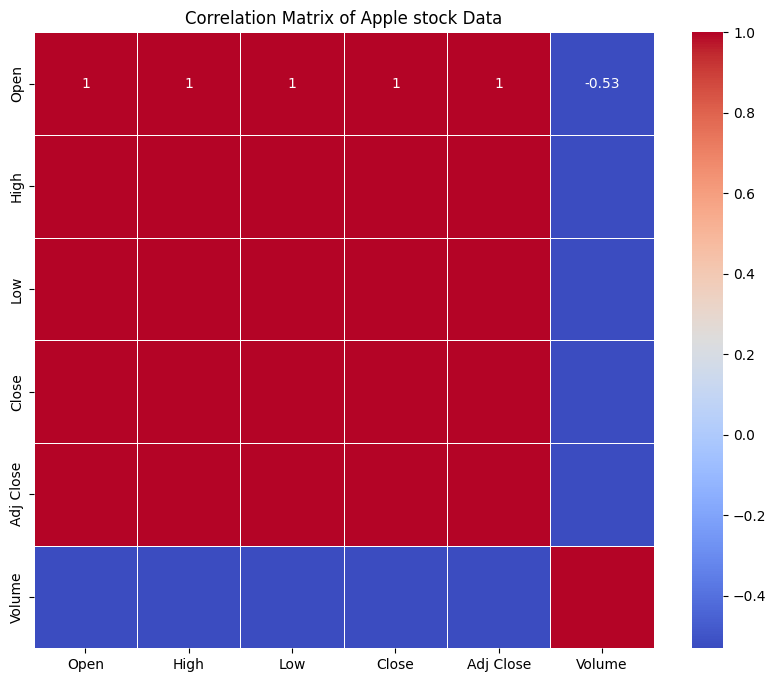

In [9]:
# Correlation Analysis
correlation_matrix = apple_data.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title('Correlation Matrix of Apple stock Data')
plt.show()

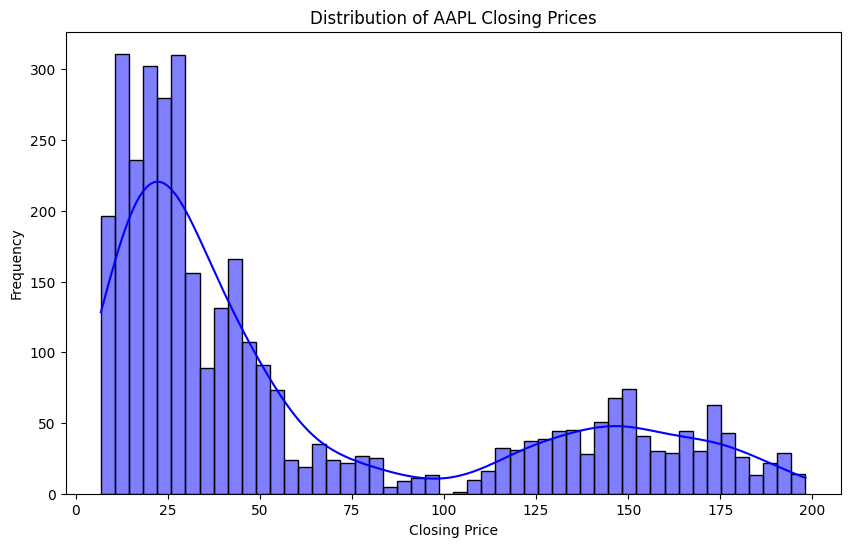

In [10]:
# Distribution of closing prices
plt.figure(figsize=(10, 6))
sns.histplot(apple_data['Close'], bins=50, kde=True, color='blue')
plt.title('Distribution of AAPL Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()


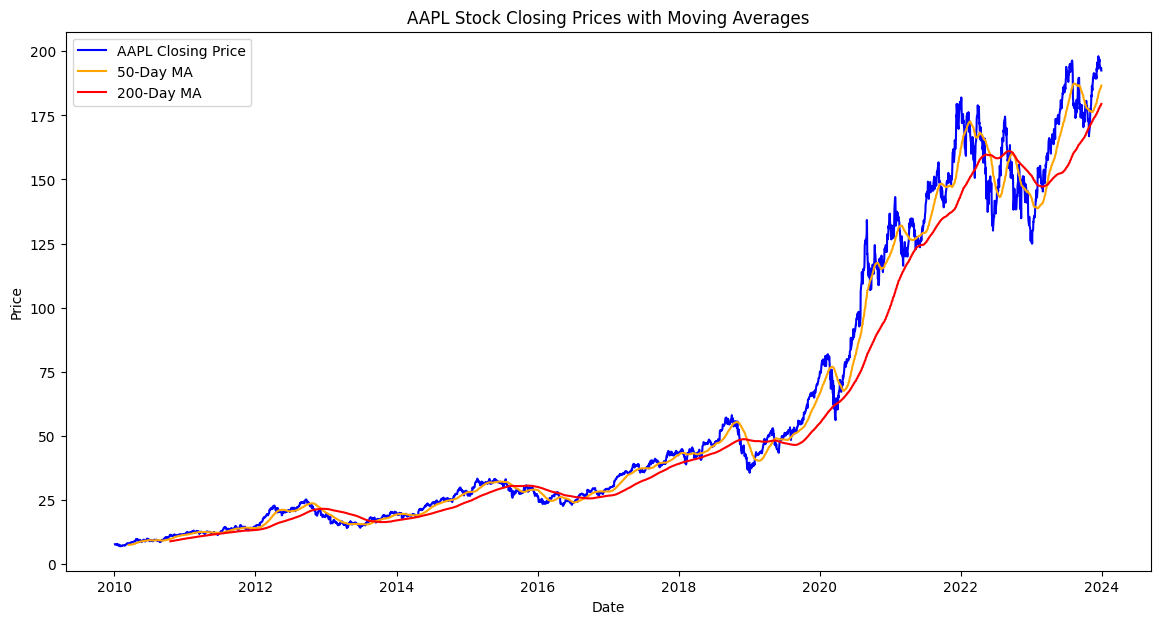

In [11]:
# Calculate moving averages
apple_data['MA50'] = apple_data['Close'].rolling(window=50).mean()
apple_data['MA200'] = apple_data['Close'].rolling(window=200).mean()

# Plot closing prices with moving averages
plt.figure(figsize=(14, 7))
plt.plot(apple_data['Close'], label='AAPL Closing Price', color='blue')
plt.plot(apple_data['MA50'], label='50-Day MA', color='orange')
plt.plot(apple_data['MA200'], label='200-Day MA', color='red')
plt.title('AAPL Stock Closing Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Data Preparation

In [11]:
# We select the 'Close' column and handle missing values
apple_close = apple_data[['Close']].dropna()

In [12]:
apple_close.index = pd.DatetimeIndex(apple_close.index).to_period('D')

### Time Series Decomposition

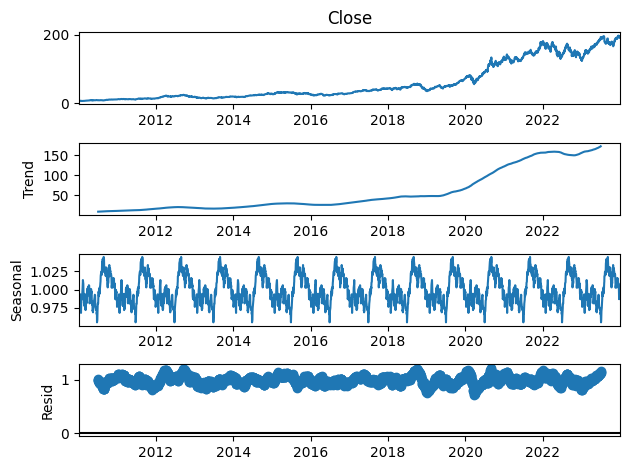

In [13]:
result = seasonal_decompose(apple_data['Close'], model='multiplicative', period=252) # 252 trading days in a year
print(result)
result.plot()
plt.show()

In [14]:
# Access and print individual components
print("Observed:\n", result.observed.head())
print("Trend:\n", result.trend.head())
print("Seasonal:\n", result.seasonal.head())
print("Residual:\n", result.resid.head())

# Summary of components
summary_df = pd.DataFrame({
    'Observed': result.observed,
    'Trend': result.trend,
    'Seasonal': result.seasonal,
    'Residual': result.resid
})
print(summary_df.head(10))

Observed:
 Date
2010-01-04    7.643214
2010-01-05    7.656429
2010-01-06    7.534643
2010-01-07    7.520714
2010-01-08    7.570714
Name: Close, dtype: float64
Trend:
 Date
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
Name: trend, dtype: float64
Seasonal:
 Date
2010-01-04    0.980277
2010-01-05    0.981511
2010-01-06    0.986363
2010-01-07    0.987689
2010-01-08    0.987734
Name: seasonal, dtype: float64
Residual:
 Date
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
Name: resid, dtype: float64
            Observed  Trend  Seasonal  Residual
Date                                           
2010-01-04  7.643214    NaN  0.980277       NaN
2010-01-05  7.656429    NaN  0.981511       NaN
2010-01-06  7.534643    NaN  0.986363       NaN
2010-01-07  7.520714    NaN  0.987689       NaN
2010-01-08  7.570714    NaN  0.987734       NaN
2010-01-11  7.503929    NaN  0.986365       NaN
2010-01-12  7.418571    NaN  0.985437   

### Stationarity Testing

In [15]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(apple_data['Close'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: 0.8198709204450109
p-value: 0.9919502443702507


In [16]:
# KPSS Test
kpss_result = kpss(apple_data['Close'], regression='c')
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

KPSS Statistic: 7.468582417538178
p-value: 0.01


c:\Users\atulp\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [18]:
# If non-stationary, apply differencing
if adf_result[1] > 0.05 or kpss_result[1] < 0.05:
    stock_data_diff = apple_data.diff().dropna()
    adf_result_diff = adfuller(stock_data_diff['Close'])
    print(f'ADF Statistic (Differenced): {adf_result_diff[0]}')
    print(f'p-value (Differenced): {adf_result_diff[1]}')

ADF Statistic (Differenced): -13.201987933901483
p-value (Differenced): 1.0897495574254808e-24


### Forecasting Model Development

In [21]:
# Split data into training and test sets
train_size = int(len(apple_data) * 0.8)
train, test = apple_data[:train_size], apple_data[train_size:]

## ARIMA Model Building and Parameter Tuning

In [22]:
# Grid Search for Best ARIMA Parameters
best_aic = float('inf')
best_order = None
best_mdl = None

for p in range(6):
    for d in range(2):
        for q in range(6):
            try:
                tmp_mdl = ARIMA(train['Close'], order=(p, d, q)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except Exception as e:
                print(f'ARIMA order ({p},{d},{q}) failed: {e}')
                continue

print('Best ARIMA order:', best_order)
print('Best AIC:', best_aic)

c:\Users\atulp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\atulp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\atulp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\atulp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Best ARIMA order: (4, 1, 5)
Best AIC: 7709.217391055037


c:\Users\atulp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\atulp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


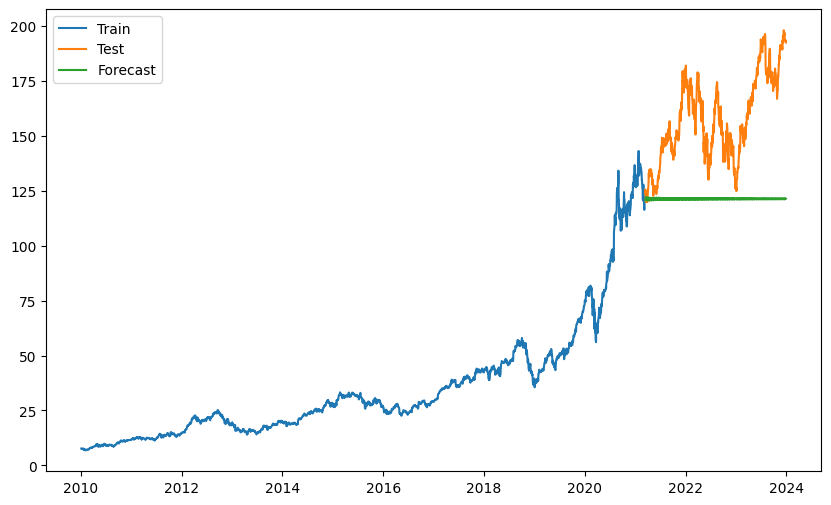

RMSE: 41.27645910944367


In [24]:
# Forecast with the best model
if best_mdl is not None:
    forecast = best_mdl.forecast(steps=len(test))

    # Ensure test and forecast indices match
    test = test.copy()  # Avoid SettingWithCopyWarning
    test['Forecast'] = forecast.values

    # Handle any NaN values in the forecast
    test = test.dropna(subset=['Forecast'])

    # Plot forecast vs actual
    plt.figure(figsize=(10, 6))
    plt.plot(train['Close'], label='Train')
    plt.plot(test['Close'], label='Test')
    plt.plot(test['Forecast'], label='Forecast')
    plt.legend()
    plt.show()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test['Close'], test['Forecast']))
    print(f'RMSE: {rmse}')
else:
    print("No suitable ARIMA model found.")